In [708]:
#*********************@Author: Aniruddh Khera*********************
# About the data: S&P500 companies stock prices from 2010-2016
# Here I analyzed for GOOGLE, we can do it for other, by automating the prcoess using grid search on best t-stats value
# Since ARIMA is for univariate TS, hence I forecasted value based on the diff of close price
# Not promising results as expected
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("prices-split-adjusted.csv")

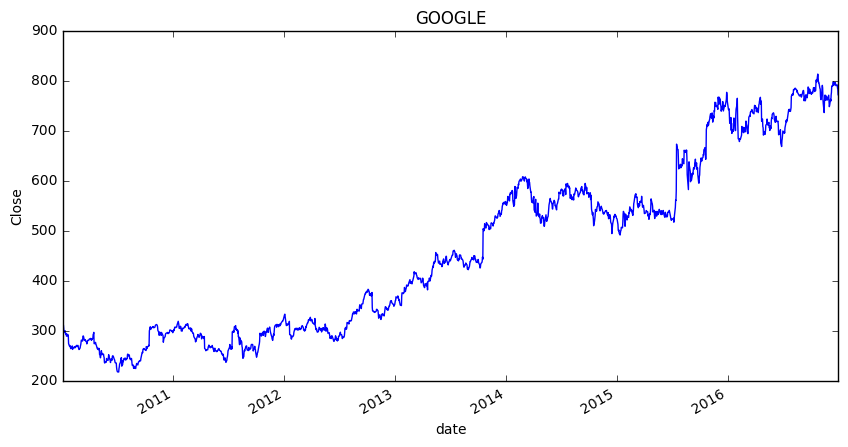

In [709]:
#**********************EXPLORATORY ANALYSIS**********************
#select google
goog = df[df.symbol == 'GOOG']
goog.date = goog.date.convert_objects(convert_dates='coerce')
goog = goog.sort_index(by="date")
goog = goog.set_index("date")
goog['close'].plot(figsize=(10,5), title="GOOGLE").set_ylabel("Close")

In [710]:
# Split data into training & testing
goog_train = goog[goog.index<'2016-12-15']
goog_test = goog[goog.index>='2016-12-15']

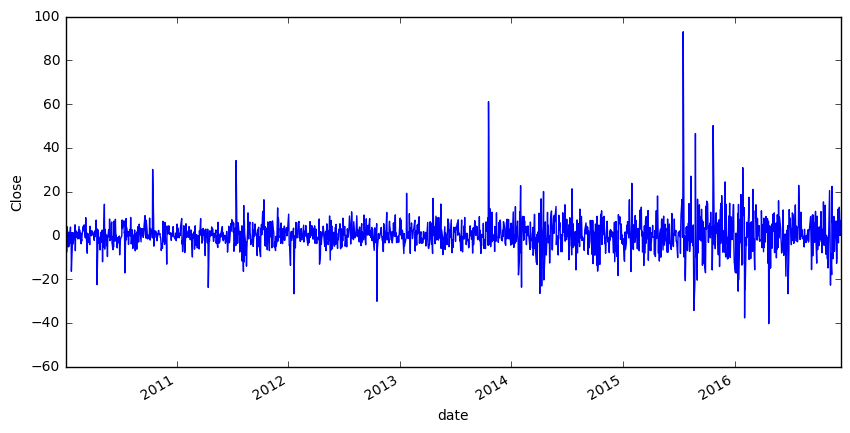

In [711]:
# Clearly unstationary 
# Take 1st difference
goog_train['First Difference'] = goog_train['close'] - goog_train['close'].shift()  
goog_train['First Difference'].plot(figsize=(10, 5)).set_ylabel("Close")  

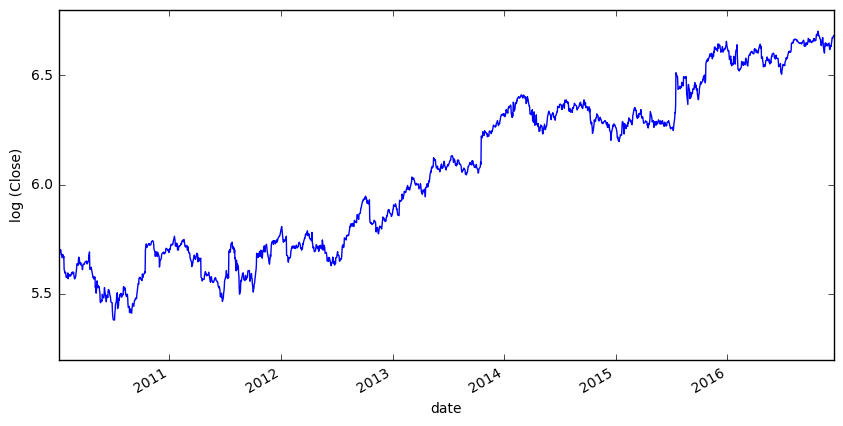

In [712]:
# Exponential smoothing by taking log to make variance constant
goog_train['Natural Log'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_train['Natural Log'].plot(figsize=(10, 5)).set_ylabel("log (Close)") 

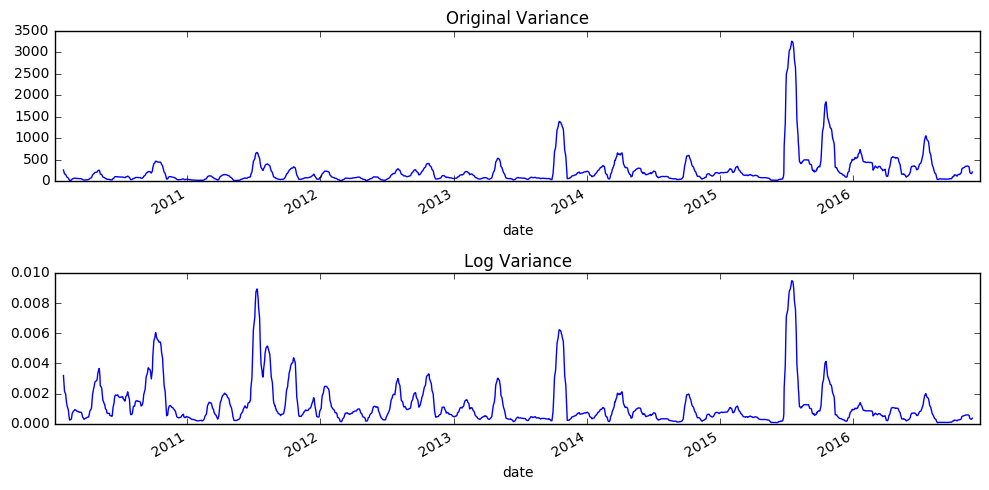

In [713]:
goog_train['Original Variance'] = pd.rolling_var(goog_train['close'], 30, min_periods=None, freq=None, center=True)  
goog_train['Log Variance'] = pd.rolling_var(goog_train['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))  
goog_train['Original Variance'].plot(ax=ax[0], title='Original Variance')  
goog_train['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

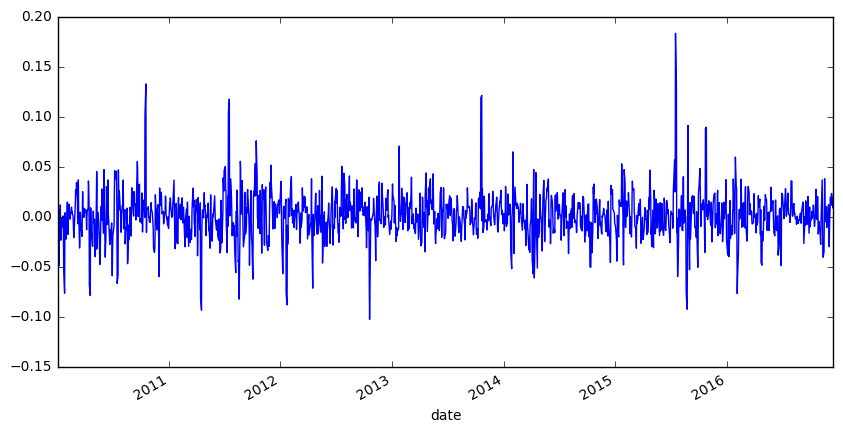

In [714]:
# goog_train['Logged First Difference'] = goog_train['Natural Log'] - goog_train['Natural Log'].shift()  
# goog_train['Logged First Difference'].plot(figsize=(10, 5))  
# goog_train['Logged First Difference'].dropna(inplace=True)
goog_train['Logged Second Difference'] = goog_train['Natural Log'] - goog_train['Natural Log'].shift(2)  
goog_train['Logged Second Difference'].plot(figsize=(10, 5))  
goog_train['Logged Second Difference'].dropna(inplace=True)

Results of Dickey-Fuller Test:
Test Statistic                -9.562051e+00
p-value                        2.411284e-16
#Lags Used                     2.300000e+01
Number of Observations Used    1.725000e+03
Critical Value (1%)           -3.434147e+00
Critical Value (10%)          -2.567663e+00
Critical Value (5%)           -2.863217e+00
dtype: float64


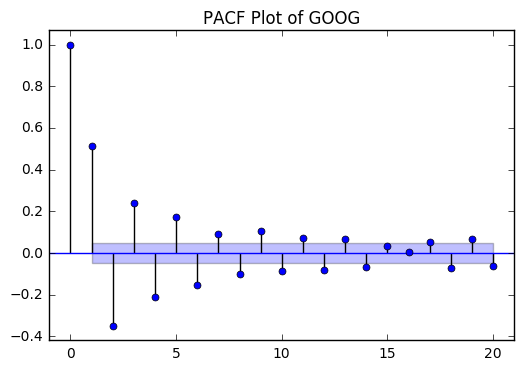

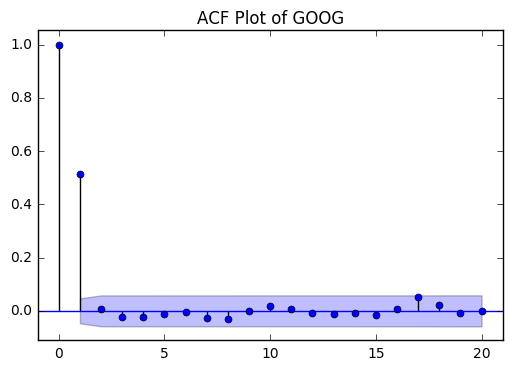

In [715]:
#Perform Dickey-Fuller test: To get the right difference based on AIC values. We get the best value 2
print('Results of Dickey-Fuller Test:')
dftest = adfuller(goog_train['Logged Second Difference'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
    
pacf = plot_pacf(goog_train['Logged Second Difference'],lags=20)
plt.title("PACF Plot of GOOG")

acf = plot_acf(goog_train['Logged Second Difference'], lags=20)
plt.title("ACF Plot of GOOG")

            
            

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1749
Model:                 ARIMA(2, 2, 0)   Log Likelihood                4533.217
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 27 Nov 2017   AIC                          -9058.434
Time:                        09:51:11   BIC                          -9036.566
Sample:                    01-06-2010   HQIC                         -9050.350
                         - 12-14-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.023e-05      0.000      0.046      0.963      -0.000       0.000
ar.L1.D2.Natural Log    -0.6467      0.023    -28.415      0.000      -0.691      -0.602
ar.L2.D2.Nat

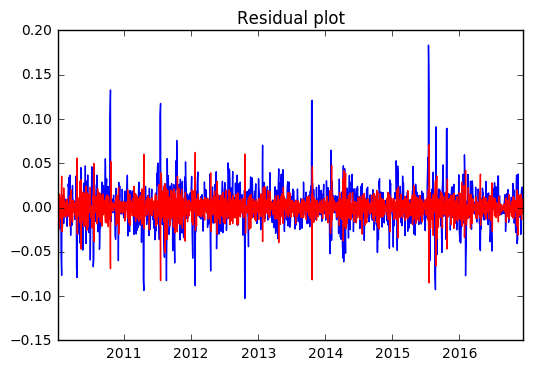

In [716]:
# AR Model
model = ARIMA(goog_train['Natural Log'], order=(2, 2, 0))  
results_AR = model.fit(disp=1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title( "Residual plot")
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1749
Model:                 ARIMA(0, 2, 1)   Log Likelihood                4783.586
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 27 Nov 2017   AIC                          -9561.172
Time:                        09:51:12   BIC                          -9544.772
Sample:                    01-06-2010   HQIC                         -9555.109
                         - 12-14-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.012e-06   2.57e-06      0.393      0.694   -4.03e-06    6.05e-06
ma.L1.D2.Natural Log    -0.9945      0.012    -80.513      0.000      -1.019      -0.970
            

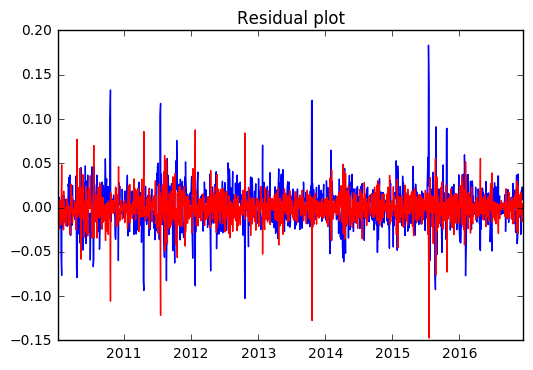

In [717]:
# MA Model
model = ARIMA(goog_train['Natural Log'], order=(0, 2, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_MA.fittedvalues, color='red')
plt.title("Residual plot")
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.Natural Log   No. Observations:                 1749
Model:                 ARIMA(2, 2, 1)   Log Likelihood                4785.171
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 27 Nov 2017   AIC                          -9560.341
Time:                        09:51:13   BIC                          -9533.007
Sample:                    01-06-2010   HQIC                         -9550.237
                         - 12-14-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.752e-07   1.05e-06      0.641      0.521   -1.39e-06    2.74e-06
ar.L1.D2.Natural Log     0.0201      0.024      0.839      0.402      -0.027       0.067
ar.L2.D2.Nat

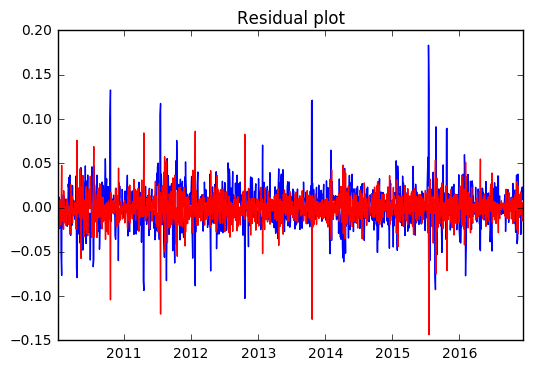

In [718]:
# ARIMA Model
model = ARIMA(goog_train['Natural Log'], order=(2, 2, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(goog_train['Logged Second Difference'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title("Residual plot")
print(results_ARIMA.summary())

In [719]:
# Take back to original scale
ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
ARIMA_diff_cumsum = ARIMA_diff.cumsum()
ARIMA_log = pd.Series(goog_train['Natural Log'])
ARIMA_log = ARIMA_log.add(ARIMA_diff_cumsum,fill_value=0)

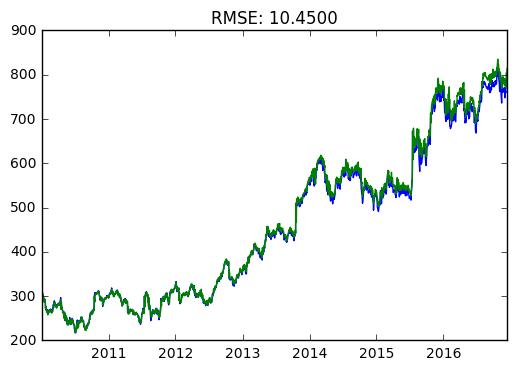

In [720]:
ARIMA_orig = np.exp(ARIMA_log)
plt.plot(goog_train['close'])
plt.plot(ARIMA_orig)
plt.title('RMSE: %.4f'% np.sqrt(sum((ARIMA_orig-goog_train['close'])**2)/len(goog_train['close'])))

                 close  Forecast Values
date                                   
2016-12-15  797.849976       799.763633
2016-12-16  790.799988       803.183634
2016-12-19  794.200012       805.635861
2016-12-20  796.419983       808.527421
2016-12-21  794.559998       811.468309
2016-12-22  791.260010       814.277526
2016-12-23  789.909973       817.193157
2016-12-27  791.549988       820.116799
2016-12-28  785.049988       823.039067
2016-12-29  782.789978       825.996678
2016-12-30  771.820007       828.968948
RMSE: 29.2116


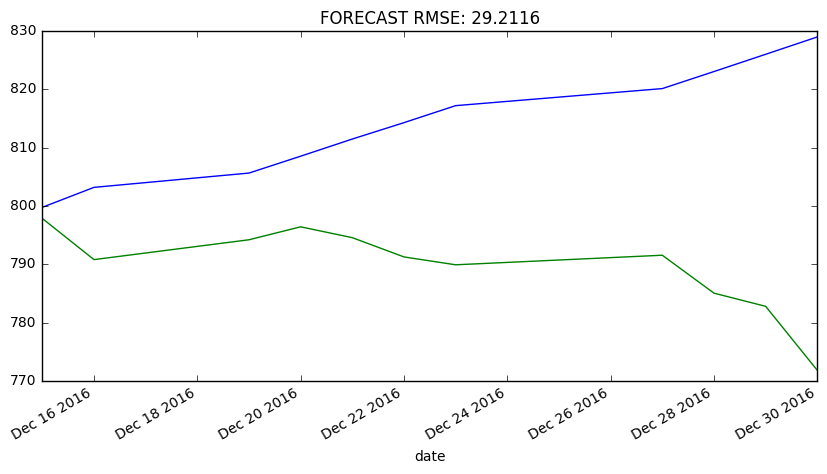

In [731]:
# Lets test on the test data
forecast_log = pd.Series(results_AR.forecast(len(goog_test['close']))[0])
forecast = np.exp(forecast_log)
goog_test['Forecast Values'] = forecast.values
print (goog_test[['close','Forecast Values']])
print ('RMSE: %.4f'% np.sqrt(sum((goog_test['Forecast Values']-goog_test['close'])**2)/len(goog_test['close'])))
goog_test['Forecast Values'].plot(figsize=(10, 5))
goog_test['close'].plot(figsize=(10, 5))
plt.title('FORECAST RMSE: %.4f'% np.sqrt(sum((goog_test['Forecast Values']-goog_test['close'])**2)/len(goog_test['close'])))